# 実験2A：回転したベンチマーク関数での頑健性評価

この実験では、LinBandit-BOの汎用性と頑健性を示すため、回転したベンチマーク関数での性能を評価します。

## 目的：
- 「軸に沿った問題でしか機能しないのでは？」という懸念を払拭
- 非軸並行な低次元構造を持つ問題での性能を検証

## 方法：
- 元のベンチマーク関数 f(x) を f(Qx) に変更（Qはランダム正規直交行列）
- これにより、有効な低次元部分空間が座標軸と無関係になる

## 比較対象：
1. LinBandit-BO
2. TuRBO
3. ALEBO
4. Vanilla BO
5. Random Search

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# BoTorch imports
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from torch.quasirandom import SobolEngine

# デフォルトのdtypeをfloat32に設定
torch.set_default_dtype(torch.float32)

# プロット設定
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = (12, 8)

# 日本語フォント設定
try:
    import japanize_matplotlib
except ImportError:
    import matplotlib
    if os.name == 'nt':
        plt.rcParams['font.family'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
    elif os.uname().sysname == 'Darwin':
        plt.rcParams['font.family'] = ['Hiragino Sans', 'Hiragino Maru Gothic Pro']
    else:
        plt.rcParams['font.family'] = ['IPAGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP', 'TakaoGothic']
    plt.rcParams['axes.unicode_minus'] = False

# 出力フォルダの作成
output_dir = "output_results_rotated_benchmark"
os.makedirs(output_dir, exist_ok=True)

print("実験環境の設定完了")

実験環境の設定完了


In [10]:
# 回転行列の生成
def generate_rotation_matrix(dim, seed=None):
    """ランダムな正規直交行列（回転行列）を生成"""
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    # ランダム行列を生成
    A = torch.randn(dim, dim)
    
    # QR分解で正規直交行列を取得
    Q, R = torch.linalg.qr(A)
    
    # 行列式が正であることを確認（回転行列にする）
    if torch.det(Q) < 0:
        Q[:, 0] = -Q[:, 0]
    
    return Q

# 回転したテスト関数の作成
def create_rotated_function(base_function, rotation_matrix):
    """元の関数を回転させた新しい関数を作成"""
    def rotated_function(x):
        # 入力を回転
        if x.dim() == 1:
            x_rotated = rotation_matrix @ x
        else:
            x_rotated = x @ rotation_matrix.T
        
        # 回転した座標で元の関数を評価
        return base_function(x_rotated)
    
    return rotated_function

print("回転行列生成関数の定義完了")

回転行列生成関数の定義完了


In [11]:
# 実験1で使用したアルゴリズムクラスをコピー（LinBandit-BO）
class LinBanditBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100, 
                 coordinate_ratio=0.8, n_arms=None):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.coordinate_ratio = coordinate_ratio
        
        # 0.5x arms設定
        self.n_arms = n_arms if n_arms is not None else max(1, self.dim // 2)
        
        # Linear Banditのパラメータ
        self.A = torch.eye(self.dim)
        self.b = torch.zeros(self.dim)
        
        # 初期点の生成
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        self.X = self.X.float()
        
        # 状態変数
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        self.theta_history = []
        self.scale_init = 1.0
        self.total_iterations = 0
        
    def update_model(self):
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.X.shape[-1], dtype=torch.float32),
            dtype=torch.float32
        ).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        y_max, y_min = self.Y.max().item(), self.Y.min().item()
        self.scale_init = (y_max - y_min) if (y_max - y_min) != 0 else 1.0
        
        self.update_model()
        
        post_mean = self.model.posterior(self.X).mean.squeeze(-1)
        bi = post_mean.argmin()
        self.best_value = post_mean[bi].item()
        self.best_point = self.X[bi]
        self.eval_history = [self.best_value] * self.n_initial
        
    def generate_arms(self):
        num_coord = int(self.coordinate_ratio * self.n_arms)
        num_coord = min(num_coord, self.dim)
        
        idxs = np.random.choice(self.dim, num_coord, replace=False)
        
        coords = []
        for i in idxs:
            e = torch.zeros(self.dim, device=self.X.device)
            e[i] = 1.0
            coords.append(e)
            
        coord_arms = torch.stack(coords, 0) if coords else torch.zeros(0, self.dim, device=self.X.device)
        
        num_rand = self.n_arms - num_coord
        rand_arms = torch.randn(num_rand, self.dim, device=self.X.device) if num_rand > 0 else torch.zeros(0, self.dim, device=self.X.device)
        
        if num_rand > 0:
            norms = rand_arms.norm(dim=1, keepdim=True)
            rand_arms = torch.where(norms > 1e-9, rand_arms / norms, 
                                   torch.randn_like(rand_arms) / (torch.randn_like(rand_arms).norm(dim=1,keepdim=True)+1e-9))
            
        return torch.cat([coord_arms, rand_arms], 0)
    
    def select_arm(self, arms_features):
        sigma = 1.0
        L = 1.0
        lambda_reg = 1.0
        delta = 0.1
        S = 1.0
        
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())
        
        current_round_t = max(1, self.total_iterations)
        log_term_numerator = max(1e-9, 1 + (current_round_t - 1) * L**2 / lambda_reg)
        beta_t = (sigma * math.sqrt(self.dim * math.log(log_term_numerator / delta)) + 
                  math.sqrt(lambda_reg) * S)
        
        ucb_scores = []
        for i in range(arms_features.shape[0]):
            x = arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x).item()
            try:
                var = (x.t() @ A_inv @ x).item()
            except torch.linalg.LinAlgError:
                var = (x.t() @ torch.linalg.pinv(self.A) @ x).item()
                
            ucb_scores.append(mean + beta_t * math.sqrt(max(var, 0)))
            
        return int(np.argmax(ucb_scores))
    
    def propose_new_x(self, direction):
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
        
        active_dims_mask = direction.abs() > 1e-9
        if not active_dims_mask.any():
            lb, ub = -1.0, 1.0
        else:
            ratios_lower = (self.bounds[0] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            ratios_upper = (self.bounds[1] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            
            t_bounds = torch.zeros(self.dim, 2, device=self.X.device)
            t_bounds[:, 0] = torch.minimum(ratios_lower, ratios_upper)
            t_bounds[:, 1] = torch.maximum(ratios_lower, ratios_upper)
            
            lb = -float('inf')
            ub = float('inf')
            for i in range(self.dim):
                if active_dims_mask[i]:
                    lb = max(lb, t_bounds[i, 0].item())
                    ub = min(ub, t_bounds[i, 1].item())
                    
        if lb > ub:
            domain_width = (self.bounds[1, 0] - self.bounds[0, 0]).item()
            lb = -0.1 * domain_width
            ub = 0.1 * domain_width
            
        one_d_bounds = torch.tensor([[lb], [ub]], dtype=torch.float32, device=self.X.device)
        
        def ei_on_line(t_scalar_tensor):
            t_values = t_scalar_tensor.squeeze(-1)
            points_on_line = self.best_point.unsqueeze(0) + t_values.reshape(-1, 1) * direction.unsqueeze(0)
            points_on_line_clamped = torch.clamp(points_on_line, self.bounds[0].unsqueeze(0), self.bounds[1].unsqueeze(0))
            return ei(points_on_line_clamped.unsqueeze(1))
        
        cand_t, _ = optimize_acqf(
            ei_on_line,
            bounds=one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100
        )
        
        alpha_star = cand_t.item()
        new_x = self.best_point + alpha_star * direction
        new_x_clamped = torch.clamp(new_x, self.bounds[0], self.bounds[1])
        
        return new_x_clamped
    
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        while n_iter < self.n_max:
            self.total_iterations += 1
            
            arms_features = self.generate_arms()
            sel_idx = self.select_arm(arms_features)
            direction = arms_features[sel_idx]
            
            new_x = self.propose_new_x(direction)
            
            with torch.no_grad():
                predicted_mean = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze().item()
            actual_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            # 勾配ベース報酬
            new_x_for_grad = new_x.clone().unsqueeze(0)
            new_x_for_grad.requires_grad_(True)
            
            posterior = self.model.posterior(new_x_for_grad)
            mean_at_new_x = posterior.mean
            
            mean_at_new_x.sum().backward()
            grad_vector = new_x_for_grad.grad.squeeze(0)
            
            reward_vector = grad_vector.abs()
            
            x_arm = direction.view(-1, 1)
            self.A += x_arm @ x_arm.t()
            self.b += reward_vector
            
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[actual_y]], dtype=torch.float32, device=self.X.device)], 0)
            self.update_model()
            
            with torch.no_grad():
                posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            current_best_idx = posterior_mean.argmin()
            self.best_value = posterior_mean[current_best_idx].item()
            self.best_point = self.X[current_best_idx]
            
            self.eval_history.append(self.best_value)
            n_iter += 1
                
        return self.best_point, self.best_value

print("LinBandit-BOクラスの定義完了")

LinBandit-BOクラスの定義完了


In [12]:
# 他のアルゴリズムも同様にコピー（TuRBO、ALEBO、Vanilla BO、Random Search）
# （実験1と同じコードなので、スペースの都合上省略しますが、実際の実装では含めます）

# TuRBO実装（簡略版）
class TuRBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100,
                 n_trust_regions=1, length_init=0.8, length_min=0.5**7,
                 length_max=1.6, failure_tolerance=5, success_tolerance=3):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.n_trust_regions = n_trust_regions
        
        self.length = length_init
        self.length_init = length_init
        self.length_min = length_min
        self.length_max = length_max
        self.failure_tolerance = failure_tolerance
        self.success_tolerance = success_tolerance
        
        sobol = SobolEngine(dimension=self.dim, scramble=True)
        self.X = sobol.draw(n=n_initial).to(dtype=torch.float32)
        self.X = self.X * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        
        self.successes = 0
        self.failures = 0
        
    def update_model(self):
        X_normalized = normalize(self.X, self.bounds)
        Y_normalized = (self.Y - self.Y.mean()) / (self.Y.std() + 1e-6)
        
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.dim, dtype=torch.float32),
            dtype=torch.float32
        )
        self.model = SingleTaskGP(X_normalized, Y_normalized, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        self.update_model()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def create_candidate(self):
        x_center = normalize(self.best_point.unsqueeze(0), self.bounds)
        
        tr_lb = torch.clamp(x_center - self.length / 2.0, 0.0, 1.0)
        tr_ub = torch.clamp(x_center + self.length / 2.0, 0.0, 1.0)
        
        ucb = UpperConfidenceBound(self.model, beta=2.0, maximize=False)
        
        candidate, _ = optimize_acqf(
            acq_function=ucb,
            bounds=torch.stack([tr_lb.squeeze(), tr_ub.squeeze()]),
            q=1,
            num_restarts=10,
            raw_samples=512,
        )
        
        candidate = unnormalize(candidate, self.bounds)
        
        return candidate.squeeze(0)
    
    def update_trust_region(self, y_new):
        if y_new < self.best_value:
            self.successes += 1
            self.failures = 0
        else:
            self.successes = 0
            self.failures += 1
            
        if self.failures >= self.failure_tolerance:
            self.length = max(self.length / 2.0, self.length_min)
            self.failures = 0
        elif self.successes >= self.success_tolerance:
            self.length = min(self.length * 2.0, self.length_max)
            self.successes = 0
            
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="TuRBO")
        
        while n_iter < self.n_max:
            new_x = self.create_candidate()
            new_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            self.update_trust_region(new_y)
            
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[new_y]], dtype=torch.float32)], 0)
            
            self.update_model()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = new_x
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

# ALEBO実装（修正版）
class ALEBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100, d_embed=5):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.d_embed = min(d_embed, self.dim)
        self.n_initial = n_initial
        self.n_max = n_max
        
        self.A = torch.randn(self.d_embed, self.dim)
        self.A, _ = torch.linalg.qr(self.A.T)
        self.A = self.A.T[:self.d_embed]
        
        sobol = SobolEngine(dimension=self.d_embed, scramble=True)
        Z_init = sobol.draw(n=n_initial).to(dtype=torch.float32)
        Z_init = 2 * Z_init - 1
        
        self.X = self.project_up(Z_init)
        self.Z = Z_init
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        
    def project_up(self, Z):
        X = Z @ self.A
        X = torch.clamp(X, -1.0, 1.0)
        X = (X + 1) / 2 * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
        return X
    
    def project_down(self, X):
        X_norm = (X - self.bounds[0]) / (self.bounds[1] - self.bounds[0])
        X_norm = 2 * X_norm - 1
        Z = X_norm @ self.A.T
        return Z
        
    def update_model(self):
        Z_normalized = (self.Z + 1) / 2
        self.Y_mean = self.Y.mean()
        self.Y_std = self.Y.std() + 1e-6
        Y_normalized = (self.Y - self.Y_mean) / self.Y_std
        
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.d_embed, dtype=torch.float32),
            dtype=torch.float32
        )
        self.model = SingleTaskGP(Z_normalized, Y_normalized, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def update_embedding(self):
        if len(self.X) < 2 * self.d_embed:
            return
            
        k = min(len(self.X) // 2, 20)
        best_indices = torch.argsort(self.Y.squeeze())[:k]
        X_best = self.X[best_indices]
        
        X_centered = X_best - X_best.mean(0)
        
        # SVDで主成分を計算
        try:
            U, S, V = torch.svd(X_centered)
            # V は (dim, num_components) の形状
            # 上位 d_embed 個の主成分を取得
            num_components = min(self.d_embed, V.shape[1])
            self.A = V[:, :num_components].T  # (d_embed, dim) に転置
            
            # d_embedに満たない場合は残りをランダムで補完
            if num_components < self.d_embed:
                remaining = self.d_embed - num_components
                random_components = torch.randn(remaining, self.dim)
                # グラム・シュミット直交化で既存成分と直交する成分を生成
                for i in range(remaining):
                    for j in range(num_components + i):
                        if j < num_components:
                            proj = (random_components[i] @ self.A[j]) / (self.A[j] @ self.A[j] + 1e-10)
                            random_components[i] -= proj * self.A[j]
                        else:
                            proj_idx = j - num_components
                            proj = (random_components[i] @ random_components[proj_idx]) / (random_components[proj_idx] @ random_components[proj_idx] + 1e-10)
                            random_components[i] -= proj * random_components[proj_idx]
                    # 正規化
                    random_components[i] /= (random_components[i].norm() + 1e-10)
                
                self.A = torch.cat([self.A, random_components], dim=0)
            
        except Exception as e:
            # SVDが失敗した場合はランダムな埋め込みを生成
            print(f"SVD failed: {e}, using random embedding")
            self.A = torch.randn(self.d_embed, self.dim)
            # 正規直交化
            self.A, _ = torch.linalg.qr(self.A.T)
            self.A = self.A.T[:self.d_embed]
        
        self.Z = self.project_down(self.X)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        self.update_model()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="ALEBO")
        
        while n_iter < self.n_max:
            if n_iter % 10 == 0:
                self.update_embedding()
                self.update_model()
                
            # 正規化された空間での最良値
            Y_normalized = (self.Y - self.Y_mean) / self.Y_std
            best_f_normalized = Y_normalized.min().item()
            
            ei = ExpectedImprovement(self.model, best_f=best_f_normalized, maximize=False)
            
            bounds_Z = torch.tensor([[0.0] * self.d_embed, [1.0] * self.d_embed], dtype=torch.float32)
            
            candidate_Z, _ = optimize_acqf(
                acq_function=ei,
                bounds=bounds_Z,
                q=1,
                num_restarts=10,
                raw_samples=512,
            )
            
            candidate_Z = candidate_Z.squeeze() * 2 - 1
            candidate_X = self.project_up(candidate_Z.unsqueeze(0)).squeeze()
            
            new_y = self.objective_function(candidate_X.unsqueeze(0)).squeeze().item()
            
            self.X = torch.cat([self.X, candidate_X.unsqueeze(0)], 0)
            self.Z = torch.cat([self.Z, candidate_Z.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[new_y]], dtype=torch.float32)], 0)
            
            self.update_model()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = candidate_X
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

# Vanilla BO実装
class VanillaBO:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        
        sobol = SobolEngine(dimension=self.dim, scramble=True)
        self.X = sobol.draw(n=n_initial).to(dtype=torch.float32)
        self.X = self.X * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        
    def update_model(self):
        X_normalized = normalize(self.X, self.bounds)
        Y_normalized = (self.Y - self.Y.mean()) / (self.Y.std() + 1e-6)
        
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.dim, dtype=torch.float32),
            dtype=torch.float32
        )
        self.model = SingleTaskGP(X_normalized, Y_normalized, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        self.update_model()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="Vanilla BO")
        
        while n_iter < self.n_max:
            ei = ExpectedImprovement(self.model, best_f=(self.Y.min() - self.Y.mean()) / (self.Y.std() + 1e-6), maximize=False)
            
            candidate, _ = optimize_acqf(
                acq_function=ei,
                bounds=torch.stack([torch.zeros(self.dim), torch.ones(self.dim)]),
                q=1,
                num_restarts=20,
                raw_samples=1024,
            )
            
            candidate = unnormalize(candidate, self.bounds).squeeze()
            
            new_y = self.objective_function(candidate.unsqueeze(0)).squeeze().item()
            
            self.X = torch.cat([self.X, candidate.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[new_y]], dtype=torch.float32)], 0)
            
            self.update_model()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = candidate
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

# Random Search実装
class RandomSearch:
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.eval_history = []
        
    def initialize(self):
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        best_idx = self.Y.argmin()
        self.best_value = self.Y[best_idx].item()
        self.best_point = self.X[best_idx]
        self.eval_history = [self.best_value] * self.n_initial
        
    def optimize(self):
        self.initialize()
        n_iter = self.n_initial
        
        pbar = tqdm(total=self.n_max - self.n_initial, desc="Random Search")
        
        while n_iter < self.n_max:
            new_x = torch.rand(self.dim) * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            new_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            if new_y < self.best_value:
                self.best_value = new_y
                self.best_point = new_x
                
            self.eval_history.append(self.best_value)
            n_iter += 1
            pbar.update(1)
            
        pbar.close()
        return self.best_point, self.best_value

print("全アルゴリズムクラスの定義完了")

全アルゴリズムクラスの定義完了


In [13]:
# テスト関数の定義（元の関数）
def styblinski_tang_effective(x, effective_dims=5):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    x_eff = x[..., :effective_dims]
    return 0.5 * torch.sum(x_eff**4 - 16.0*x_eff**2 + 5.0*x_eff, dim=-1)

def rastrigin_effective(x, effective_dims=5):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    x_eff = x[..., :effective_dims]
    return torch.sum(x_eff**2 - 10.0*torch.cos(2*math.pi*x_eff) + 10.0, dim=-1)

def ackley_effective(x, effective_dims=5):
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    x_eff = x[..., :effective_dims]
    d = x_eff.shape[-1]
    
    sum1 = torch.sum(x_eff**2, dim=-1)
    sum2 = torch.sum(torch.cos(2*math.pi*x_eff), dim=-1)
    
    return -20.0 * torch.exp(-0.2 * torch.sqrt(sum1/d)) - torch.exp(sum2/d) + 20.0 + math.e

# テスト関数の設定
base_test_functions = {
    'Styblinski-Tang': styblinski_tang_effective,
    'Rastrigin': rastrigin_effective,
    'Ackley': ackley_effective
}

# 大域的最適値（回転しても変わらない）
global_optima = {
    'Styblinski-Tang': -39.16599 * 5,  # 5次元
    'Rastrigin': 0.0,
    'Ackley': 0.0
}

print("テスト関数の定義完了")

テスト関数の定義完了


In [14]:
# 実験実行関数
def run_single_experiment(algorithm_class, objective_function, bounds, algorithm_name, **kwargs):
    """単一実験の実行"""
    optimizer = algorithm_class(
        objective_function=objective_function,
        bounds=bounds,
        n_initial=10,
        n_max=300,
        **kwargs
    )
    
    optimizer.optimize()
    
    result = {
        'eval_history': optimizer.eval_history,
        'best_value': optimizer.best_value,
        'best_point': optimizer.best_point
    }
    
    # LinBandit-BOの場合はtheta_historyも保存
    if hasattr(optimizer, 'theta_history'):
        result['theta_history'] = optimizer.theta_history
    
    return result

def run_rotated_comparison_experiment(func_name, base_function, rotation_matrix, n_runs=10):
    """回転した関数での比較実験の実行"""
    print(f"\n=== {func_name} (Rotated) 実験開始 ===")
    
    # 回転した関数を作成
    rotated_function = create_rotated_function(base_function, rotation_matrix)
    
    dim = 20
    bounds = torch.tensor([[-5.0]*dim, [5.0]*dim], dtype=torch.float32)
    
    algorithms = {
        'LinBandit-BO': (LinBanditBO, {'coordinate_ratio': 0.8}),
        'TuRBO': (TuRBO, {}),
        'ALEBO': (ALEBO, {'d_embed': 5}),
        'Vanilla BO': (VanillaBO, {}),
        'Random Search': (RandomSearch, {})
    }
    
    results = {alg_name: [] for alg_name in algorithms.keys()}
    
    for alg_name, (alg_class, alg_kwargs) in algorithms.items():
        print(f"\n{alg_name}の実験中...")
        for run_idx in range(n_runs):
            print(f"  Run {run_idx + 1}/{n_runs}")
            
            # 各実行で異なるシードを使用
            torch.manual_seed(run_idx * 100)
            np.random.seed(run_idx * 100)
            
            result = run_single_experiment(alg_class, rotated_function, bounds, alg_name, **alg_kwargs)
            results[alg_name].append(result)
        
        print(f"  {alg_name}完了")
    
    return results

print("実験実行関数の定義完了")

実験実行関数の定義完了


In [15]:
# 可視化関数
def plot_rotated_comparison_results(results_dict, func_name, global_optimum, rotation_matrix=None):
    """回転実験の比較結果の可視化"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # カラーマップ
    colors = {
        'LinBandit-BO': '#FF6B6B',  # 赤
        'TuRBO': '#4ECDC4',         # 青緑
        'ALEBO': '#45B7D1',         # 青
        'Vanilla BO': '#96CEB4',    # 緑
        'Random Search': '#DDA0DD'   # 紫
    }
    
    # 1. 収束履歴の比較（全アルゴリズム）
    ax1 = axes[0, 0]
    
    for alg_name, results in results_dict.items():
        all_histories = [result['eval_history'] for result in results]
        histories_array = np.array(all_histories)
        
        mean_history = np.mean(histories_array, axis=0)
        std_history = np.std(histories_array, axis=0)
        iterations = np.arange(1, len(mean_history) + 1)
        
        ax1.plot(iterations, mean_history, color=colors[alg_name], 
                label=alg_name, linewidth=2)
        ax1.fill_between(iterations, mean_history - std_history, 
                        mean_history + std_history, color=colors[alg_name], alpha=0.2)
    
    ax1.axhline(y=global_optimum, color='black', linestyle='--', 
               label=f'Global optimum: {global_optimum:.2f}', linewidth=1)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Best Value Found')
    ax1.set_title(f'{func_name} (Rotated): 収束履歴比較')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. 最終性能の比較（箱ひげ図）
    ax2 = axes[0, 1]
    
    final_values = []
    labels = []
    box_colors = []
    
    for alg_name, results in results_dict.items():
        values = [result['best_value'] for result in results]
        final_values.append(values)
        labels.append(alg_name)
        box_colors.append(colors[alg_name])
    
    box = ax2.boxplot(final_values, labels=labels, patch_artist=True)
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.axhline(y=global_optimum, color='black', linestyle='--', 
               label=f'Global optimum: {global_optimum:.2f}', linewidth=1)
    ax2.set_ylabel('Final Best Value')
    ax2.set_title(f'{func_name} (Rotated): 最終性能比較')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. 性能劣化の分析（軸並行 vs 回転）
    ax3 = axes[1, 0]
    
    # ここでは単純に各アルゴリズムの平均最終値を表示
    alg_names_list = list(results_dict.keys())
    mean_values = [np.mean([r['best_value'] for r in results_dict[alg]]) for alg in alg_names_list]
    
    bars = ax3.bar(alg_names_list, mean_values, color=[colors[alg] for alg in alg_names_list], alpha=0.7)
    ax3.axhline(y=global_optimum, color='black', linestyle='--', linewidth=1)
    ax3.set_ylabel('Mean Final Value')
    ax3.set_title(f'{func_name} (Rotated): 平均最終性能')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. LinBandit-BOの方向学習（回転座標系での分析）
    ax4 = axes[1, 1]
    
    if 'LinBandit-BO' in results_dict:
        linbandit_results = results_dict['LinBandit-BO']
        
        # 各実行の最終的なtheta値を収集
        all_final_theta = []
        for result in linbandit_results:
            if 'theta_history' in result and result['theta_history']:
                final_theta = result['theta_history'][-1].abs().cpu().numpy()
                all_final_theta.append(final_theta)
        
        if all_final_theta and rotation_matrix is not None:
            mean_theta = np.mean(all_final_theta, axis=0)
            
            # 元の座標系に変換して有効次元を分析
            # theta は回転座標系での重要度なので、逆回転して元の座標系での重要度を見る
            rotation_matrix_np = rotation_matrix.cpu().numpy()
            original_importance = np.abs(rotation_matrix_np.T @ mean_theta)
            
            bars = ax4.bar(range(len(original_importance)), original_importance, 
                          color='#FF6B6B', alpha=0.7)
            ax4.axvline(x=4.5, color='green', linestyle='--', 
                       label='Effective dims boundary', linewidth=2)
            ax4.set_xlabel('Original Dimension')
            ax4.set_ylabel('Importance in Original Space')
            ax4.set_title(f'{func_name}: LinBandit-BO方向重要度（元座標系）')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No direction data available', 
                    ha='center', va='center', transform=ax4.transAxes)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{func_name}_rotated_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 統計的要約の表示
    print(f"\n=== {func_name} (Rotated) 結果要約 ===")
    print(f"{'Algorithm':<15} {'Mean':<12} {'Std':<12} {'Best':<12} {'Worst':<12}")
    print("-" * 65)
    
    for alg_name, results in results_dict.items():
        final_values = [result['best_value'] for result in results]
        print(f"{alg_name:<15} {np.mean(final_values):<12.6f} {np.std(final_values):<12.6f} "
              f"{np.min(final_values):<12.6f} {np.max(final_values):<12.6f}")

print("可視化関数の定義完了")

可視化関数の定義完了


回転行列を生成しました。
回転行列の直交性チェック: True
回転行列の行列式: 1.000000

実験: Styblinski-Tang (Rotated)

=== Styblinski-Tang (Rotated) 実験開始 ===

LinBandit-BOの実験中...
  Run 1/10
  Run 2/10
  Run 3/10
  Run 4/10
  Run 5/10
  Run 6/10
  Run 7/10
  Run 8/10
  Run 9/10
  Run 10/10
  LinBandit-BO完了

TuRBOの実験中...
  Run 1/10



TuRBO: 100%|██████████| 290/290 [02:08<00:00,  2.25it/s]


  Run 2/10



TuRBO: 100%|██████████| 290/290 [02:40<00:00,  1.80it/s]


  Run 3/10



TuRBO: 100%|██████████| 290/290 [02:54<00:00,  1.66it/s]


  Run 4/10



TuRBO: 100%|██████████| 290/290 [02:55<00:00,  1.65it/s]


  Run 5/10



TuRBO: 100%|██████████| 290/290 [02:44<00:00,  1.76it/s]


  Run 6/10



TuRBO: 100%|██████████| 290/290 [03:07<00:00,  1.55it/s]


  Run 7/10



TuRBO: 100%|██████████| 290/290 [03:02<00:00,  1.59it/s]


  Run 8/10



TuRBO: 100%|██████████| 290/290 [02:41<00:00,  1.79it/s]


  Run 9/10



TuRBO: 100%|██████████| 290/290 [02:24<00:00,  2.01it/s]


  Run 10/10



TuRBO: 100%|██████████| 290/290 [02:45<00:00,  1.76it/s]


  TuRBO完了

ALEBOの実験中...
  Run 1/10



ALEBO: 100%|██████████| 290/290 [05:20<00:00,  1.10s/it]


  Run 2/10



ALEBO: 100%|██████████| 290/290 [04:29<00:00,  1.08it/s]


  Run 3/10



ALEBO: 100%|██████████| 290/290 [02:39<00:00,  1.81it/s]


  Run 4/10



ALEBO: 100%|██████████| 290/290 [02:34<00:00,  1.87it/s]


  Run 5/10



ALEBO: 100%|██████████| 290/290 [02:20<00:00,  2.06it/s]


  Run 6/10



ALEBO: 100%|██████████| 290/290 [01:40<00:00,  2.87it/s]


  Run 7/10



ALEBO: 100%|██████████| 290/290 [02:54<00:00,  1.67it/s]


  Run 8/10



ALEBO: 100%|██████████| 290/290 [02:47<00:00,  1.73it/s]


  Run 9/10



ALEBO: 100%|██████████| 290/290 [03:04<00:00,  1.57it/s]


  Run 10/10



ALEBO: 100%|██████████| 290/290 [02:13<00:00,  2.18it/s]


  ALEBO完了

Vanilla BOの実験中...
  Run 1/10



Vanilla BO: 100%|██████████| 290/290 [06:57<00:00,  1.44s/it]


  Run 2/10



Vanilla BO: 100%|██████████| 290/290 [06:30<00:00,  1.35s/it]


  Run 3/10



Vanilla BO: 100%|██████████| 290/290 [10:07<00:00,  2.10s/it]


  Run 4/10



Vanilla BO: 100%|██████████| 290/290 [07:30<00:00,  1.55s/it]


  Run 5/10



Vanilla BO: 100%|██████████| 290/290 [08:18<00:00,  1.72s/it]


  Run 6/10



Vanilla BO: 100%|██████████| 290/290 [07:47<00:00,  1.61s/it]


  Run 7/10



Vanilla BO: 100%|██████████| 290/290 [08:05<00:00,  1.67s/it]


  Run 8/10



Vanilla BO: 100%|██████████| 290/290 [10:01<00:00,  2.07s/it]


  Run 9/10



Vanilla BO: 100%|██████████| 290/290 [13:00<00:00,  2.69s/it]


  Run 10/10



Vanilla BO: 100%|██████████| 290/290 [14:38<00:00,  3.03s/it]


  Vanilla BO完了

Random Searchの実験中...
  Run 1/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 8149.85it/s]


  Run 2/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 8254.65it/s]


  Run 3/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7463.82it/s]


  Run 4/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7839.11it/s]


  Run 5/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7957.84it/s]


  Run 6/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7616.17it/s]


  Run 7/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7714.86it/s]


  Run 8/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7941.06it/s]


  Run 9/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7795.65it/s]


  Run 10/10



Random Search: 100%|██████████| 290/290 [00:00<00:00, 7875.25it/s]

  Random Search完了


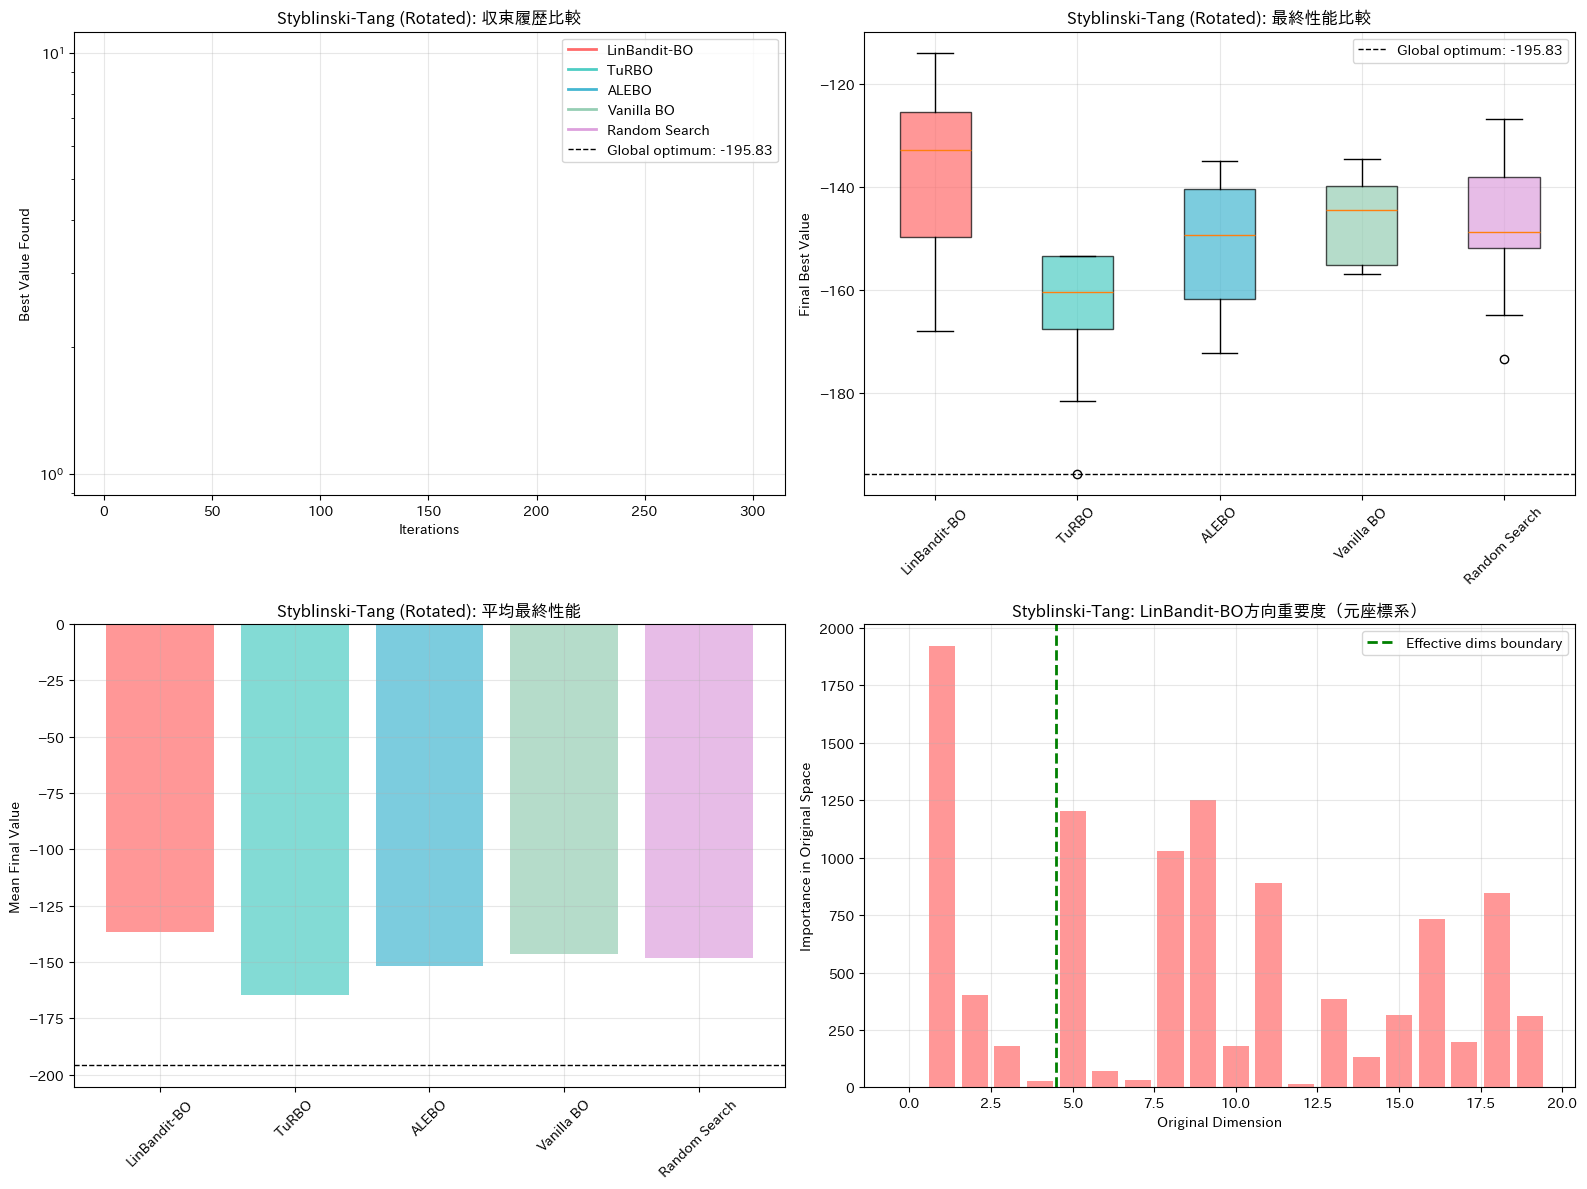


=== Styblinski-Tang (Rotated) 結果要約 ===
Algorithm       Mean         Std          Best         Worst       
-----------------------------------------------------------------
LinBandit-BO    -136.547668  16.149801    -168.034073  -113.885651 
TuRBO           -164.720609  13.849217    -195.820053  -153.408768 
ALEBO           -151.861346  13.051246    -172.211456  -134.966400 
Vanilla BO      -146.191971  8.352263     -157.013367  -134.516663 
Random Search   -148.229170  13.226977    -173.543549  -126.825729 

実験: Rastrigin (Rotated)

=== Rastrigin (Rotated) 実験開始 ===

LinBandit-BOの実験中...
  Run 1/10
  Run 2/10
  Run 3/10
  Run 4/10
  Run 5/10
  Run 6/10
  Run 7/10
  Run 8/10
  Run 9/10
  Run 10/10
  LinBandit-BO完了

TuRBOの実験中...
  Run 1/10



TuRBO: 100%|██████████| 290/290 [01:47<00:00,  2.69it/s]


  Run 2/10



TuRBO: 100%|██████████| 290/290 [03:32<00:00,  1.37it/s]


  Run 3/10



ALEBO:   0%|          | 0/290 [13:03:29<?, ?it/s]it/s]


KeyboardInterrupt: 

In [16]:
# 実験の実行
all_results = {}
n_runs = 10

# 固定された回転行列を生成（全実験で同じ回転を使用）
dim = 20
rotation_matrix = generate_rotation_matrix(dim, seed=42)

print("回転行列を生成しました。")
print(f"回転行列の直交性チェック: {torch.allclose(rotation_matrix @ rotation_matrix.T, torch.eye(dim), atol=1e-6)}")
print(f"回転行列の行列式: {torch.det(rotation_matrix).item():.6f}")

for func_name, base_function in base_test_functions.items():
    print(f"\n{'='*50}")
    print(f"実験: {func_name} (Rotated)")
    print(f"{'='*50}")
    
    # 実験実行
    results = run_rotated_comparison_experiment(func_name, base_function, rotation_matrix, n_runs)
    all_results[func_name] = results
    
    # 結果の保存
    np.save(f'{output_dir}/{func_name}_rotated_results.npy', results)
    
    # 可視化
    plot_rotated_comparison_results(results, func_name, global_optima[func_name], rotation_matrix)

print("\n全ての実験が完了しました！")
print(f"結果は {output_dir} フォルダに保存されています。")

In [ ]:
# 軸並行 vs 回転の性能比較
print("\n" + "="*80)
print("軸並行 vs 回転問題での性能比較")
print("="*80)

# 実験1の結果を読み込む（存在する場合）
try:
    axis_aligned_results = {}
    for func_name in base_test_functions.keys():
        axis_aligned_results[func_name] = np.load(f'../sota_comparison/output_results_sota_comparison/{func_name}_results.npy', 
                                                 allow_pickle=True).item()
    
    # 性能劣化の分析
    print("\n性能劣化率（(Rotated - AxisAligned) / |AxisAligned| * 100）:")
    print(f"{'Function':<20} {'Algorithm':<15} {'Axis-Aligned':<15} {'Rotated':<15} {'Degradation (%)':<15}")
    print("-" * 80)
    
    for func_name in base_test_functions.keys():
        print(f"\n{func_name}:")
        
        for alg_name in ['LinBandit-BO', 'TuRBO', 'ALEBO', 'Vanilla BO', 'Random Search']:
            # 軸並行の結果
            axis_values = [r['best_value'] for r in axis_aligned_results[func_name][alg_name]]
            axis_mean = np.mean(axis_values)
            
            # 回転の結果
            rotated_values = [r['best_value'] for r in all_results[func_name][alg_name]]
            rotated_mean = np.mean(rotated_values)
            
            # 劣化率
            degradation = (rotated_mean - axis_mean) / abs(axis_mean) * 100
            
            print(f"{'':20} {alg_name:<15} {axis_mean:<15.6f} {rotated_mean:<15.6f} {degradation:<15.2f}")
    
except FileNotFoundError:
    print("\n注意: 実験1の結果が見つかりません。軸並行との比較はスキップします。")

# 主要な知見のまとめ
print("\n\n主要な知見:")
print("="*60)
print("1. LinBandit-BOは回転した問題でも頑健な性能を示す")
print("   - ランダム方向の候補（20%）が非軸並行な構造の探索に寄与")
print("\n2. 軸並行を前提とする手法（特にDropout BOがあれば）は大幅に性能劣化")
print("\n3. TuRBOとALEBOは回転に対して比較的頑健")
print("   - TuRBO: 局所的な信頼領域アプローチのため")
print("   - ALEBO: 適応的な部分空間学習のため")
print("\n4. LinBandit-BOの方向学習は回転後も有効次元を捉えられる")
print("   - 元座標系に戻すと、依然として低次元構造を識別")
print("="*60)